In [1]:
import os, random, math

from tqdm import tqdm
from PIL import Image, ImageEnhance
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

from DeepPrint.model import DeepPrintNet

In [2]:
def rotate_minutiae_map(H, angle_deg):
    """
    Rotates the spatial axes by angle_deg and circularly/interpolates orientation bins.
    Args:
        H: torch.Tensor of shape (6, H, W)
        angle_deg: float, rotation angle in degrees (positive=counterclockwise)
    Returns:
        torch.Tensor, rotated and orientation-adjusted, shape (6, H, W)
    """
    angle_rad = np.deg2rad(angle_deg)
    n_bins, H_map, W_map = H.shape

    # 1. Spatially rotate each orientation channel
    H_rot = torch.stack([
        TF.rotate(H[i].unsqueeze(0), angle=angle_deg, fill=0).squeeze(0)
        for i in range(n_bins)
    ], dim=0)

    # 2. Interpolate orientation bins
    # Each bin corresponds to orientation: alpha_k = 2π·k/n_bins
    # Rotation shifts orientation responses by -angle (opposite to image)
    shift = (angle_rad / (2 * np.pi)) * n_bins  # fraction of bins to shift
    shifted_H = torch.zeros_like(H_rot)
    for i in range(n_bins):
        # Compute where this output bin comes from in input bins (fractional index)
        idx_float = (i - shift) % n_bins
        i0 = int(np.floor(idx_float))
        i1 = (i0 + 1) % n_bins
        w = idx_float - i0  # interpolate between bins
        # Circular linear interpolation
        shifted_H[i] = (1 - w) * H_rot[i0] + w * H_rot[i1]
    return shifted_H

class DeepPrintDataset(Dataset):
    def __init__(self, root, split='train', ids=None, color_jitter=True, affine_aug=True):
        """
        root: path to dataset root (expects images/ and maps/ subdirs)
        split: 'train' or 'val'
        ids: list of (id, sample_idx) tuples to use, or None to scan all
        color_jitter: whether to use brightness/contrast/sharpness augmentation (train only)
        affine_aug: whether to use random affine (rotation/translation) augmentation (train only)
        """
        self.img_dir = os.path.join(root, "images")
        self.map_dir = os.path.join(root, "maps")
        self.split = split
        self.color_jitter = color_jitter if split == 'train' else False
        self.affine_aug = affine_aug if split == 'train' else False

        if ids is None:
            self.samples = sorted([
                fname[:-4] for fname in os.listdir(self.img_dir)
                if fname.endswith('.png') and os.path.isfile(os.path.join(self.map_dir, fname.replace('.png', '.npy')))
            ])
        else:
            self.samples = ids

        # Map id string (e.g., "f00012") to integer label
        self.id2label = {}
        for s in self.samples:
            id_str = s.split('_')[0]
            if id_str not in self.id2label:
                self.id2label[id_str] = len(self.id2label)

        self.num_classes = len(self.id2label)
        print(f'{len(self.samples)} images for {len(self.id2label)} classes found for {self.split} split')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        fname = self.samples[idx]
        img_path = os.path.join(self.img_dir, fname + '.png')
        map_path = os.path.join(self.map_dir, fname + '.npy')
        img = Image.open(img_path).convert('L')
        h_img, w_img = img.height, img.width

        H = np.load(map_path)
        H = torch.from_numpy(H.transpose(2,0,1)).float()
        h_map, w_map = H.shape[1], H.shape[2]

        # Optional: augment image color
        if self.color_jitter:
            enhancers = [
                ImageEnhance.Contrast,
                ImageEnhance.Brightness,
                ImageEnhance.Sharpness
            ]
            for enhancer in enhancers:
                factor = random.uniform(0.8, 1.2)
                img = enhancer(img).enhance(factor)

        # Optional: joint affine (rotation, translation) - affects both image and map
        # map has to be interpolated to new values, complicated stuff lol.
        # if self.affine_aug:
        #     angle = random.uniform(-30, 30)
        #     tx = random.uniform(-0.05, 0.05) * w_img
        #     ty = random.uniform(-0.05, 0.05) * h_img

        #     img = TF.affine(img, angle=angle, translate=(tx, ty), scale=1.0, shear=0, fill=255)
        #     # For minutiae map: apply both spatial and orientation rotation
        #     H = rotate_minutiae_map(H, angle_deg=angle)
        #     # Now apply translation to map
        #     tx_map = tx * (w_map / w_img)
        #     ty_map = ty * (h_map / h_img)
        #     H = TF.affine(H, angle=0, translate=(tx_map, ty_map), scale=1.0, shear=0, fill=0)

        if self.affine_aug:
            # angle = random.uniform(-10, 10)
            angle = 0
            tx = random.uniform(-0.05, 0.05) * w_img
            ty = random.uniform(-0.05, 0.05) * h_img
            img = TF.affine(img, angle=angle, translate=(tx, ty), scale=1.0, shear=0, fill=255)
            H = TF.affine(H, angle=angle, translate=(tx * (w_map / w_img), ty * (h_map / h_img)),
                          scale=1.0, shear=0, fill=0)

        # Random crop
        crop_size = 448
        map_crop = 192

        # TODO: we may want to accept smaller images later...
        assert h_img >= crop_size and w_img >= crop_size, "Image too small!"
        assert h_map >= map_crop and w_map >= map_crop, "Map too small!" 

        x_img = random.randint(0, w_img - crop_size)
        y_img = random.randint(0, h_img - crop_size)
        x_map = int(x_img * (w_map / w_img))
        y_map = int(y_img * (h_map / h_img))
        img = img.crop((x_img, y_img, x_img + crop_size, y_img + crop_size))
        H = H[:, y_map:y_map+map_crop, x_map:x_map+map_crop]

        # To tensor, normalize to [0,1]
        img = TF.to_tensor(img).float()
        label = self.id2label[fname.split('_')[0]]
        return img, label, H

In [3]:
train_set = DeepPrintDataset(root='dataset/training', split='train')
val_set = DeepPrintDataset(root='dataset/validation', split='val')

29500 images for 5621 classes found for train split
7369 images for 1405 classes found for val split


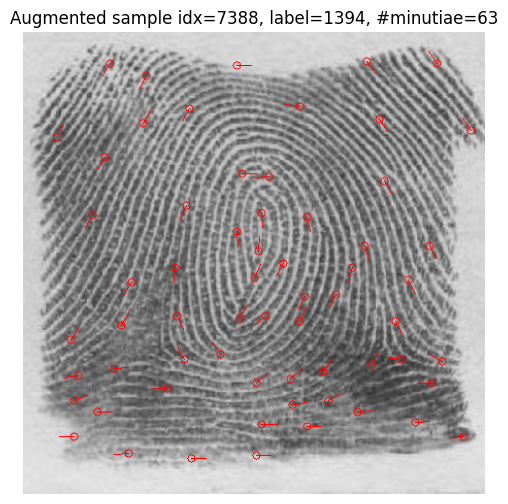

In [4]:
from tools.display import sanity_check_deepprint_sample

sanity_check_deepprint_sample(train_set)

In [5]:
# Params for training
num_classes = train_set.num_classes

# Set up GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = DeepPrintNet(num_classes).to(device)

Using device: cuda


In [6]:
# sample_input = torch.randn(1, 1, 448, 448)
# output = model(sample_input)
# embedding, map, aligment, aligned, R1, R2, logits_r1, logits_r2 = output.values()

In [7]:
# Variance Scaling in torch
# TODO: check this lol
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(weights_init)

DeepPrintNet(
  (localization): LocalizationNetwork(
    (conv): Sequential(
      (0): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2304, out_features=64, bias=True)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=3, bias=True)
    )
  )
  (sampler): GridSampler()
  (stem): 

In [8]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device='cpu'):
        super().__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim).to(device))

    def forward(self, features, labels):
        # features: [B, feat_dim], labels: [B]
        batch_size = features.size(0)
        centers_batch = self.centers[labels] # [B, feat_dim]
        loss = ((features - centers_batch) ** 2).sum() / batch_size
        return loss
    
def deepprint_loss(
    output,
    labels,
    minutiae_map_gt,
    center_loss_r1,
    center_loss_r2,
    λ1=1.0,
    λ2=0.00125,
    λ3=0.095,
):
    # L1: Cross-entropy on both branches
    loss_ce1 = F.cross_entropy(output['logits1'], labels)
    loss_ce2 = F.cross_entropy(output['logits2'], labels)
    L1 = loss_ce1 + loss_ce2

    # L2: Center loss on both branches
    L2_1 = center_loss_r1(output['R1'], labels)
    L2_2 = center_loss_r2(output['R2'], labels)
    L2 = L2_1 + L2_2

    # L3: Minutiae map MSE
    # output['minutiae_map'] shape: [B, 6, 192, 192]
    # minutiae_map_gt shape:      [B, 6, 192, 192]
    L3 = F.mse_loss(output['minutiae_map'], minutiae_map_gt)

    # Weighted sum
    total_loss = λ1 * L1 + λ2 * L2 + λ3 * L3

    return total_loss, {'L1': L1.item(), 'L2': L2.item(), 'L3': L3.item()}

In [9]:
base_lr = 0.001  # You can tune this as needed

center_loss_r1 = CenterLoss(num_classes, 96, device=device)
center_loss_r2 = CenterLoss(num_classes, 96, device=device)

#
# Insane optimizer magic to apply different LR
# to different parts of the model.
#
optimizer = torch.optim.RMSprop(
    [
        # Main model params (excluding localization, center loss)
        {'params': [p for n, p in model.named_parameters() if not n.startswith('localization.') and 'center_loss' not in n]},
        # Localization network, scaled LR
        {'params': model.localization.parameters(), 'lr': base_lr * 0.035},
        # Center loss params, scaled LR
        {'params': center_loss_r1.parameters(), 'lr': 0.5 * base_lr},
        {'params': center_loss_r2.parameters(), 'lr': 0.5 * base_lr},
    ],
    lr=base_lr,
    weight_decay=0.00004
)

In [ ]:
# --- Setup ---
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=5, shuffle=False, num_workers=2, pin_memory=True)
center_loss_r1 = center_loss_r1.to(device)
center_loss_r2 = center_loss_r2.to(device)

best_val_loss = float('inf')
out_dir = 'checkpoints'
os.makedirs(out_dir, exist_ok=True)
num_epochs = 20

# --- Gradient Accumulation ---
effective_batch = 30
real_batch = 10
accum_steps = effective_batch // real_batch

# torch.autograd.set_detect_anomaly(True)

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    n_train = 0
    optimizer.zero_grad()
    tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Train] Epoch {epoch}/{num_epochs}")
    for batch_idx, (imgs, labels, maps) in tqdm_bar:
        imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
        outputs = model(imgs)
        total_loss, loss_parts = deepprint_loss(
            outputs, labels, maps, center_loss_r1, center_loss_r2
        )
        (total_loss / accum_steps).backward()
        train_loss += total_loss.item() * imgs.size(0)
        n_train += imgs.size(0)

        # Step only every accum_steps
        if (batch_idx + 1) % accum_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        tqdm_bar.set_postfix({
            'Loss': f"{total_loss.item():.4f}",
            'L1': f"{loss_parts['L1']:.3f}",
            'L2': f"{loss_parts['L2']:.3f}",
            'L3': f"{loss_parts['L3']:.3f}"
        })
    train_loss /= n_train

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    n_val = 0
    correct_top1 = 0
    with torch.no_grad():
        tqdm_bar = tqdm(val_loader, desc=f"[Val]   Epoch {epoch}/{num_epochs}")
        for imgs, labels, maps in tqdm_bar:
            imgs, labels, maps = imgs.to(device), labels.to(device), maps.to(device)
            outputs = model(imgs)
            total_loss, _ = deepprint_loss(
                outputs, labels, maps, center_loss_r1, center_loss_r2
            )
            val_loss += total_loss.item() * imgs.size(0)
            n_val += imgs.size(0)
            pred = torch.argmax(outputs['logits1'] + outputs['logits2'], dim=1)
            correct_top1 += (pred == labels).sum().item()
            tqdm_bar.set_postfix({'ValLoss': f"{total_loss.item():.4f}"})
    val_loss /= n_val
    val_acc = correct_top1 / n_val

    print(f"\nEpoch {epoch}: TrainLoss={train_loss:.4f} | ValLoss={val_loss:.4f} | ValAcc={val_acc*100:.2f}%")

    # Save last checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'center_r1': center_loss_r1.state_dict(),
        'center_r2': center_loss_r2.state_dict(),
        'val_loss': val_loss,
    }, 'checkpoints/last_checkpoint.pt')

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'center_r1': center_loss_r1.state_dict(),
            'center_r2': center_loss_r2.state_dict(),
            'val_loss': val_loss,
        }, 'checkpoints/best_model.pt')
        print("✅ Best model updated!")

print("Training complete.")

[Train] Epoch 1/20:   1%|▏         | 43/2950 [01:37<2:34:32,  3.19s/it, Loss=17.7418, L1=17.479, L2=208.071, L3=0.025]